In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)

devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: future
Loading ychr


In [2]:
read_dp <- function(arch, capture, coverages) {
    arch_gt <-
        future_map(coverages, function(x) {
            read_vcf(here(paste0("data/vcf/", capture, "_", arch, ".vcf.gz")), mindp = x, var_only = TRUE) %>%
                select(!!arch) %>%
                setNames(paste0(arch, "_dp", x))
        }) %>% bind_cols

    pos <- read_vcf(here(paste0("data/vcf/", capture, "_", arch, ".vcf.gz")), mindp = 1, var_only = TRUE) %>%
        select(chrom, pos, REF, ALT)
    
    bind_cols(pos, arch_gt)
}

## Read genotypes

In [3]:
gt_den4 %<-% read_dp("den4", "full", 1:10)
gt_den8 %<-% read_dp("den8", "full", 1:10)
gt_spy1 %<-% read_dp("spy1", "full", 1:10)
gt_mez2 %<-% read_dp("mez2", "full", 1:10)

In [4]:
gt_elsidron1 %<-% read_dp("elsidron1", "exome", 1:10)
gt_elsidron2 %<-% read_dp("elsidron2", "lippold", 1:10)

In [5]:
gt_high <-
    read_vcf(here(paste0("data/vcf/full_highcov.vcf.gz")), mindp = 3, var_only = TRUE) %>%
    select(chrom, pos, REF, ALT, S_French_1, S_Papuan_2, S_Burmese_1, S_Thai_1, S_Sardinian_1)

## Calculate proportions of genotyped SNP

In [6]:
raw_den4 <- snp_props(gt_den4)
raw_den8 <- snp_props(gt_den8)
raw_spy1 <- snp_props(gt_spy1)
raw_mez2 <- snp_props(gt_mez2)
raw_high <- snp_props(gt_high)

In [7]:
raw_elsidron1 <- snp_props(gt_elsidron1)
raw_elsidron2 <- snp_props(gt_elsidron2)

In [8]:
den4 <- snp_props(gt_den4, normalize = "T-C")
den8 <- snp_props(gt_den8, normalize = "T-C")
spy1 <- snp_props(gt_spy1, normalize = "T-C")
mez2 <- snp_props(gt_mez2, normalize = "T-C")
high <- snp_props(gt_high, normalize = "T-C")

In [9]:
elsidron1 <- snp_props(gt_elsidron1, normalize = "T-C")
elsidron2 <- snp_props(gt_elsidron2, normalize = "T-C")

Average out the modern human SNP counts to have a baseline to compare ancient samples to:

In [10]:
modern <- select(high, -snp) %>%
    mutate(snp = high$snp, modern = rowMeans(.)) %>%
    select(snp, modern) %>%
    gather(mindp, proportion, -snp)

Bind all ancient SNP counts into a single data frame:

In [11]:
props <- bind_rows(
    den8 %>% gather(mindp, proportion, -snp) %>% mutate(ind = "Denisova 8"),
    den4 %>% gather(mindp, proportion, -snp) %>% mutate(ind = "Denisova 4"),
    spy1 %>% gather(mindp, proportion, -snp) %>% mutate(ind = "Spy 1"),
    mez2 %>% gather(mindp, proportion, -snp) %>% mutate(ind = "Mezmaiskaya 2"),
    elsidron1 %>% gather(mindp, proportion, -snp) %>% mutate(ind = "El Sidrón 1253 (118 kb)"),
    elsidron2 %>% gather(mindp, proportion, -snp) %>% mutate(ind = "El Sidrón 1253")
) %>%
    mutate(mindp = as.factor(as.numeric(str_replace(mindp, ".*_dp", ""))))

Warning message:
“Unknown levels in `f`: El Sidrón 1253 (560 kb), El Sidrón 1253 (118 kb)”

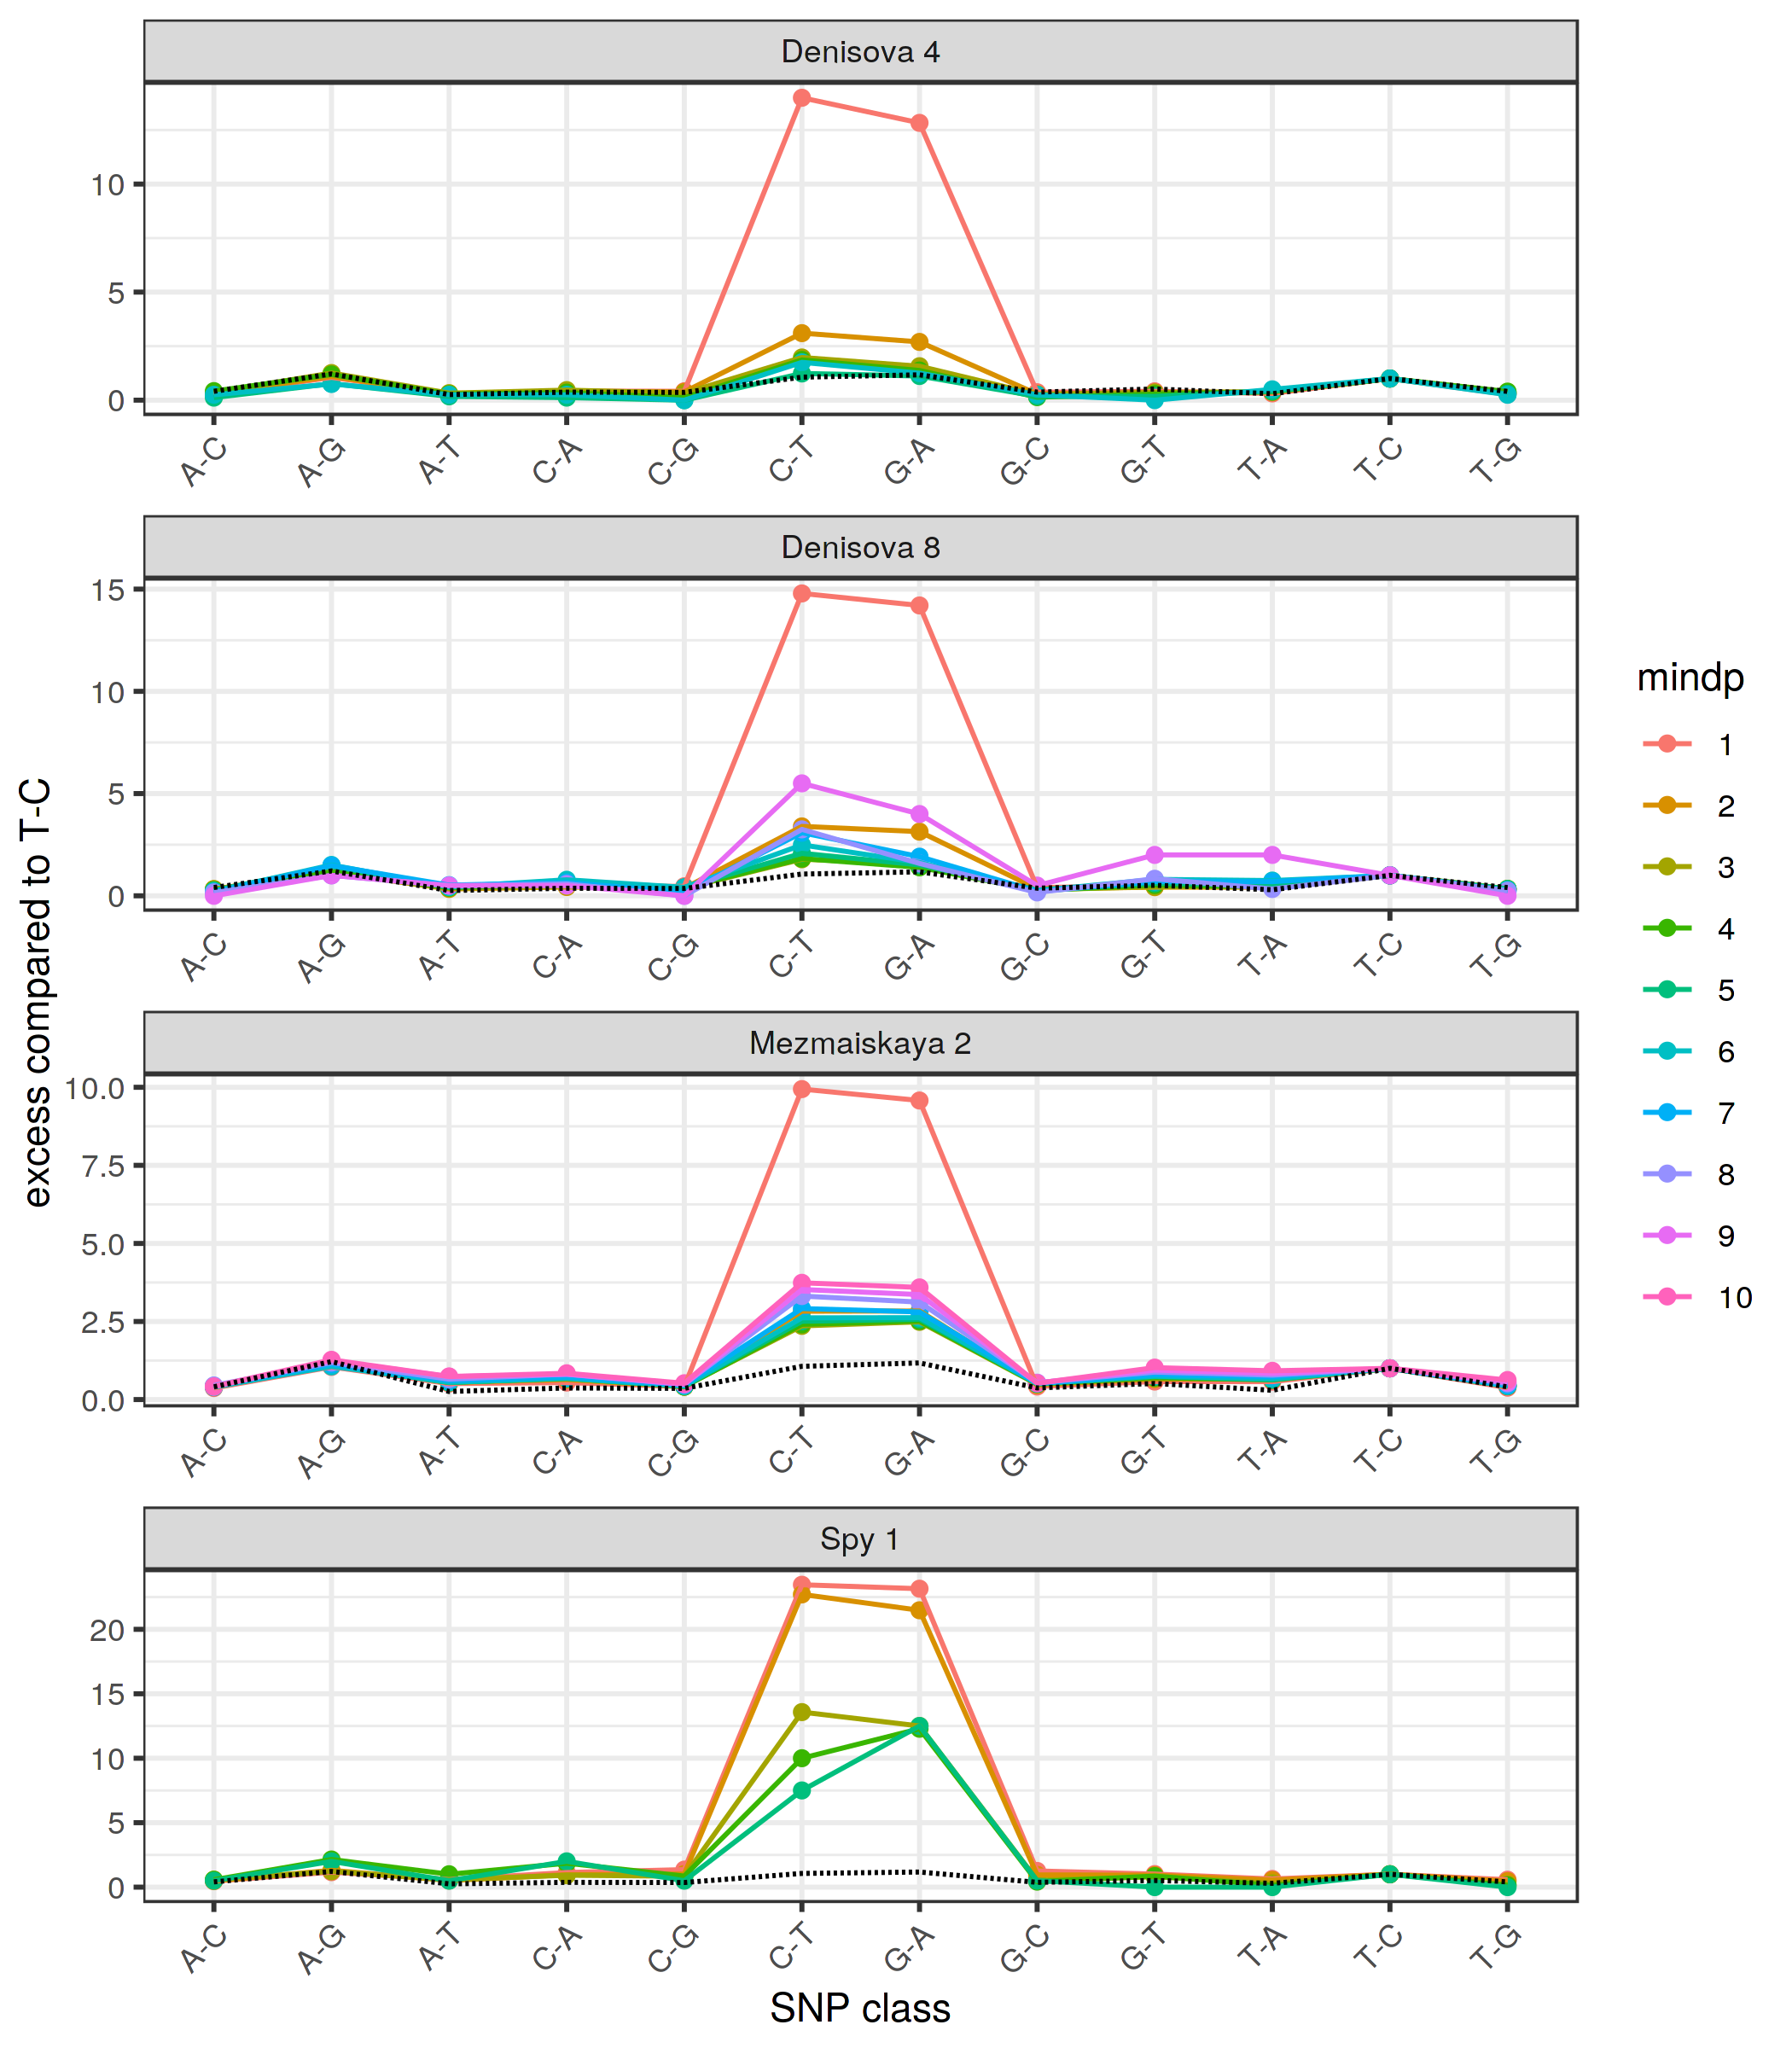

In [12]:
set_dim(7, 8)

props %>%
filter(!is.infinite(proportion), !is.nan(proportion)) %>%
filter(!str_detect(ind, "El Sidrón")) %>%
mutate(ind = fct_relevel(ind, "El Sidrón 1253 (560 kb)", "El Sidrón 1253 (118 kb)", after = Inf)) %>%
ggplot(aes(snp, proportion, color = mindp)) +
    geom_point() +
    geom_line(aes(group = mindp)) +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    xlab("SNP class") + ylab("excess compared to T-C") +
    guides(linetype = FALSE, shape = FALSE) +
    geom_line(data = modern, group = 1, color = "black", linetype = 2) +
    facet_wrap(~ ind, scales = "free", ncol = 1)

ggsave(here("figures/snp_proportions_full.png"), width = 7, height = 8)

Warning message:
“Unknown levels in `f`: El Sidrón 1253 (560 kb)”

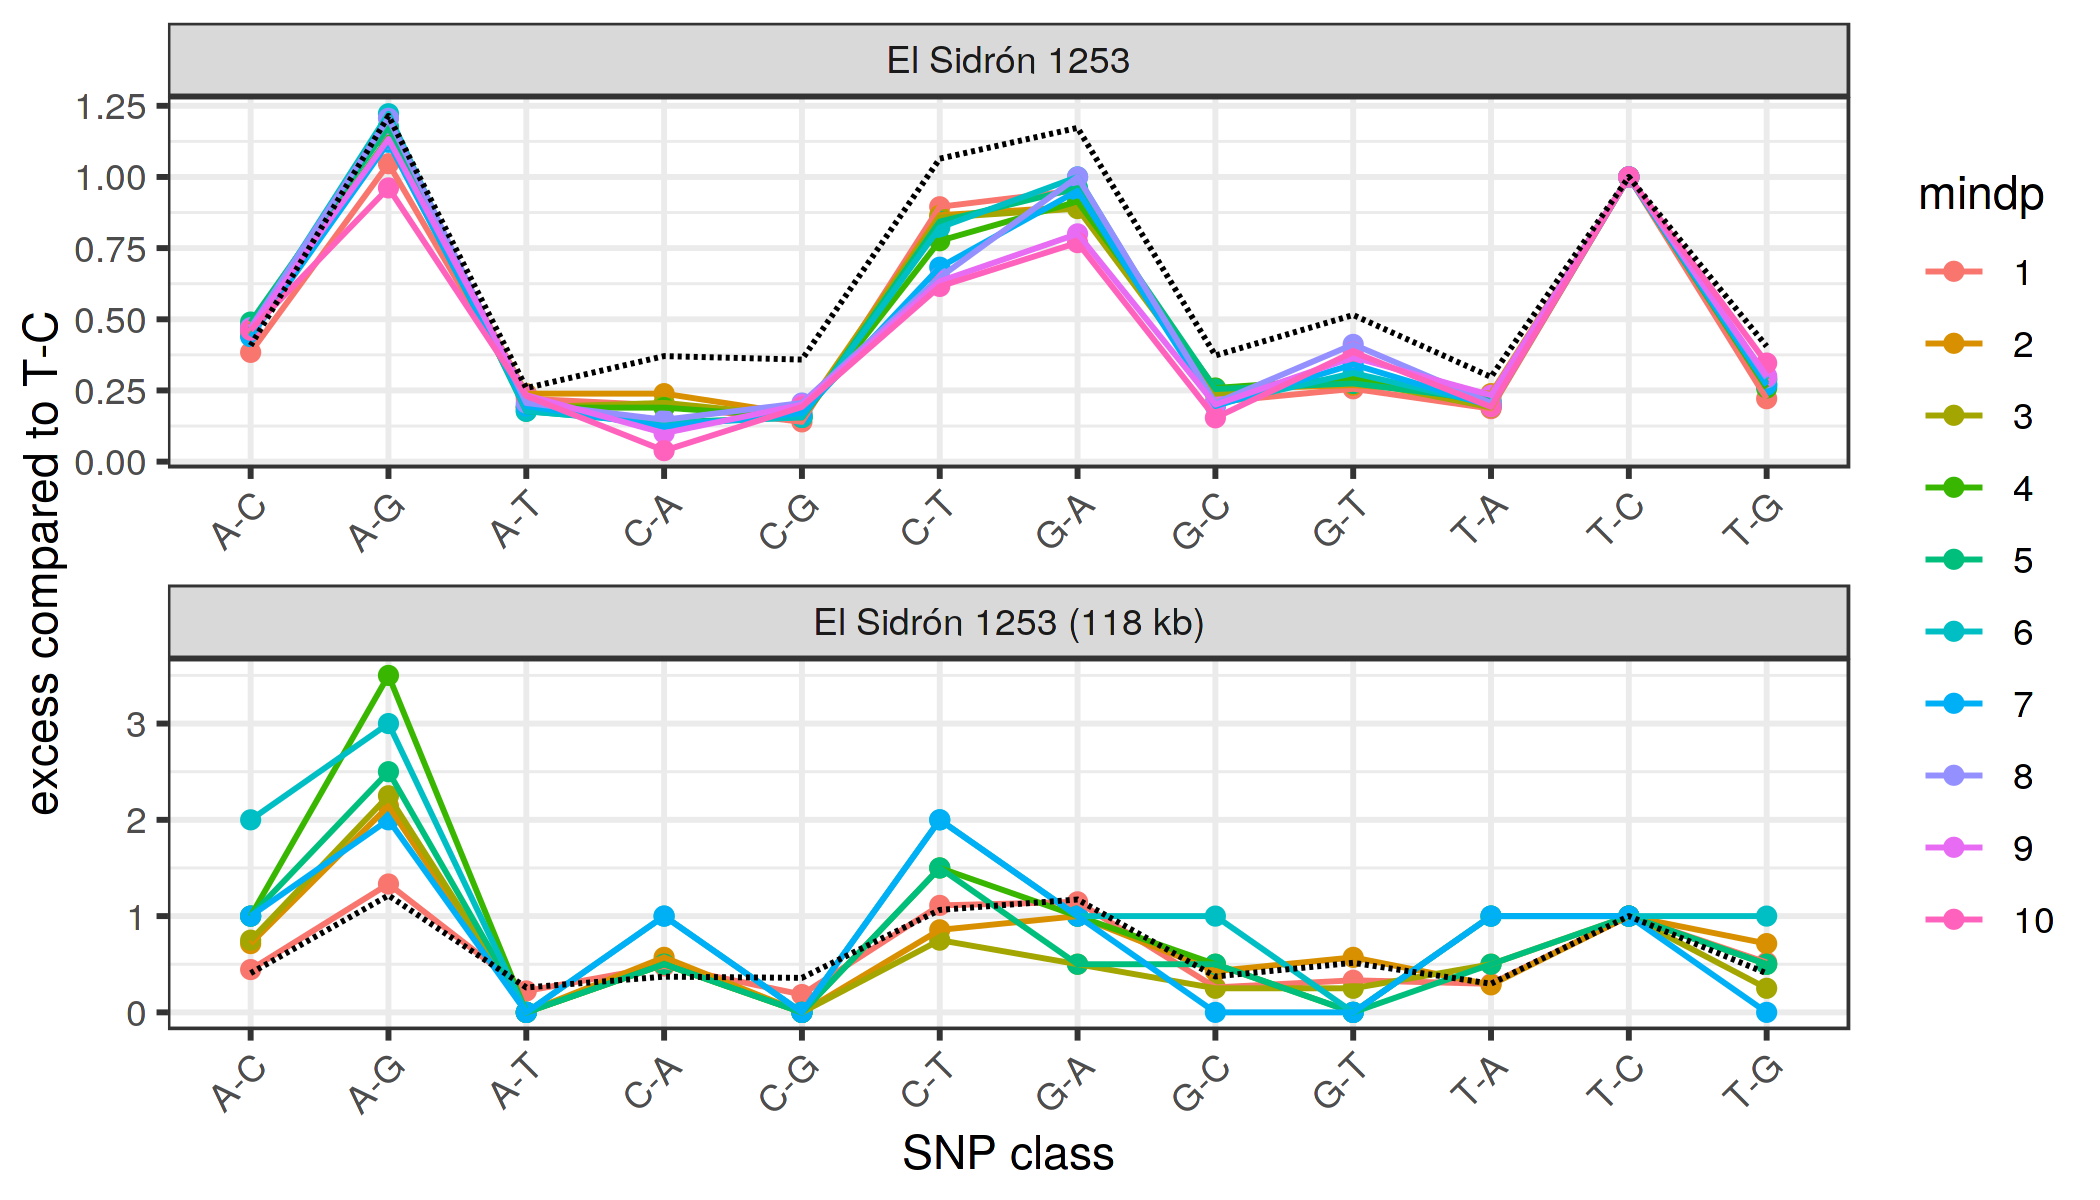

In [13]:
set_dim(7, 4)

props %>%
filter(!is.infinite(proportion), !is.nan(proportion)) %>%
filter(str_detect(ind, "El Sidrón")) %>%
mutate(ind = fct_relevel(ind, "El Sidrón 1253 (560 kb)", "El Sidrón 1253 (118 kb)", after = Inf)) %>%
ggplot(aes(snp, proportion, color = mindp)) +
    geom_point() +
    geom_line(aes(group = mindp)) +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    xlab("SNP class") + ylab("excess compared to T-C") +
    guides(linetype = FALSE, shape = FALSE) +
    geom_line(data = modern, group = 1, color = "black", linetype = 2) +
    facet_wrap(~ ind, scales = "free", ncol = 1)

ggsave(here("figures/snp_proportions_elsidron.png"), width = 7, height = 4)